In [1]:
# !pip install -q catboost==1.1.1
# !pip install -q matplotlib-venn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.4 MB/s eta 0:00:00


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time
import itertools
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import display, clear_output
from catboost import Pool, CatBoostRanker

In [4]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [5]:
from google.colab import output
output.enable_custom_widget_manager()

In [6]:
# Подключение данных гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

In [7]:
from catboost.datasets import msrank_10k

train_df, test_df = msrank_10k()
print(f"train_df: {train_df.shape[0]:,} x {train_df.shape[1]:,}")
train_df.sort_values(by=[1], ascending=True, inplace=True)
display(train_df.head(2))
print(f"test_df: {test_df.shape[0]:,} x {test_df.shape[1]:,}")
test_df.sort_values(by=[1], ascending=True, inplace=True)
display(test_df.head(2))

X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values

train_df: 10,000 x 138


,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,1,3,3,0,0,3,1.0,1.0,0.0,...,62,11089534,2,116,64034,13,3,0,0,0.0
62,0.0,1,3,0,3,0,3,1.0,0.0,1.0,...,44,5,30,23836,63634,2,4,0,0,0.0


test_df: 10,000 x 138


,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,13,2,0,2,1,2,1.0,0.0,1.0,...,35,1,0,266,25070,28,7,0,0,0.0
102,1.0,13,2,0,2,0,2,1.0,0.0,1.0,...,23,53,0,15435,4867,10,108,0,0,0.0


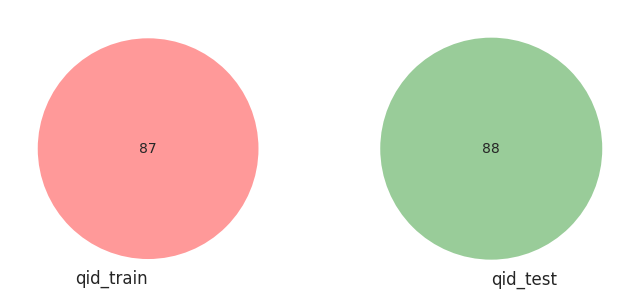

In [8]:
from matplotlib_venn import venn2
venn2(
    subsets=[
        set(queries_train),
        set(queries_test),
    ],
    set_labels=['qid_train', 'qid_test']
);

In [74]:
#################### making groups #########################
train_groups_dict = {}
unq_queries = np.unique(queries_train)
i = 0
for query_id in tqdm(unq_queries):
  train_groups_dict[query_id] = [
      (idx, rel_score) for idx, rel_score in enumerate(y_train[queries_train == query_id], start=i)
  ]
  i += len(train_groups_dict[query_id])
train_group_idxs = list(itertools.chain.from_iterable([[key]*len(vals) for key, vals in train_groups_dict.items()]))

######################### making pairs #########################
pairs = []
for group_id, docs_and_relevances in tqdm(train_groups_dict.items()):
  for (doci, reli), (docj, relj) in itertools.combinations(docs_and_relevances, 2):
    if reli > relj:
      pairs.append((doci, docj))
    else:
      pairs.append((docj, doci))
print(len(pairs))

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

740487


In [14]:
from catboost import Pool, CatBoostRanker

In [78]:
train_pool = Pool(
    data=X_train,
    label=y_train / np.max(y_train),
    group_id=train_group_idxs,
    pairs=pairs
)

test_pool = Pool(
    data=X_test,
    label=y_test / np.max(y_test),
    group_id=queries_test,
    # pairs=pairs
)

In [79]:
cbr = CatBoostRanker(
    iterations=1000,
    learning_rate=0.05,
    # loss_function='PairLogitPairwise',
    loss_function='YetiRankPairwise',
    eval_metric='NDCG',
    verbose=20,
    task_type='GPU',
)
cbr.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6471616	best: 0.6471616 (0)	total: 18.3ms	remaining: 18.3s
20:	test: 0.7302277	best: 0.7302277 (20)	total: 337ms	remaining: 15.7s
40:	test: 0.7313227	best: 0.7314236 (35)	total: 647ms	remaining: 15.1s
60:	test: 0.7368255	best: 0.7368255 (60)	total: 957ms	remaining: 14.7s
80:	test: 0.7343360	best: 0.7368255 (60)	total: 1.27s	remaining: 14.4s
100:	test: 0.7386716	best: 0.7388079 (95)	total: 1.58s	remaining: 14s
120:	test: 0.7387429	best: 0.7391867 (105)	total: 1.89s	remaining: 13.7s
140:	test: 0.7416370	best: 0.7431247 (135)	total: 2.2s	remaining: 13.4s
160:	test: 0.7434251	best: 0.7435499 (155)	total: 2.52s	remaining: 13.1s
180:	test: 0.7427357	best: 0.7437211 (175)	total: 2.83s	remaining: 12.8s
200:	test: 0.7431648	best: 0.7437339 (185)	total: 3.15s	remaining: 12.5s
220:	test: 0.7437605	best: 0.7437605 (220)	total: 3.46s	remaining: 12.2s
240:	test: 0.7440272	best: 0.7440272 (240)	total: 3.76s	remaining: 11.8s
260:	test: 0.7448078	best: 0.7448147 (250)	total: 4.06s	remaining:

<Axes: ylabel='Density'>

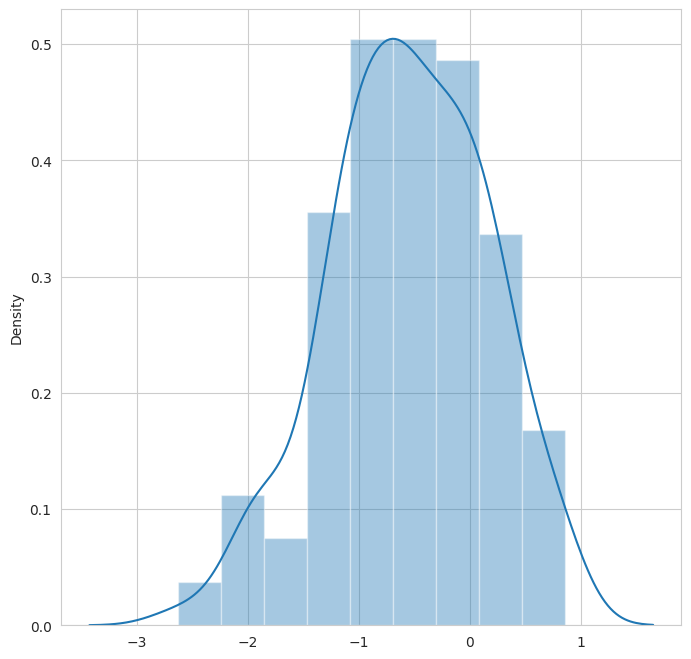

In [81]:
queries_test_set = np.unique(queries_test)
sns.distplot(cbr.predict(X_test[queries_test == queries_test_set[0]]));

In [84]:
# ######################### making pairs with weight #########################
# pairs = []
# for group_id, docs_and_relevances in tqdm(train_groups_dict.items()):
#   for (doci, reli), (docj, relj) in itertools.combinations(docs_and_relevances, 2):
#     if reli > relj:
#       pairs.append((doci, docj, reli - relj))
#     else:
#       pairs.append((docj, doci, relj - reli))
# print(len(pairs))

In [85]:
# train_pool = Pool(
#     data=X_train,
#     label=y_train / np.max(y_train),
#     group_id=train_group_idxs,
#     pairs=pairs
# )

# test_pool = Pool(
#     data=X_test,
#     label=y_test / np.max(y_test),
#     group_id=queries_test,
#     # pairs=pairs
# )

In [86]:
# cbr = CatBoostRanker(
#     iterations=1000,
#     learning_rate=0.05,
#     # loss_function='PairLogitPairwise',
#     loss_function='YetiRankPairwise',
#     eval_metric='NDCG',
#     verbose=20,
#     task_type='GPU',
# )
# cbr.fit(train_pool, eval_set=test_pool, plot=True)